<a href="https://colab.research.google.com/github/parthatom/UnsupervisedClassification/blob/master/UnSupervisedLearning_SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning on Synthetic Sparse and Uniform Data

## Importing

In [0]:
import torch
import torchvision
import sys
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import sklearn
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
colors = ['y', 'r']

In [0]:
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import mixture
import torchvision.transforms as transforms
from torchvision import models
import time

## Data Creation

In [0]:
seed = 42
torch.random.manual_seed(seed)

### Sparse Data

In [0]:
def Sparse():
  m =  torch.zeros((39,1))
  m[torch.randint(low = 0, high = 39, size=(1,1)).item()]= 1
  X = m
  # print(X.shape)
  for i in range(5000):
    noise = torch.randn_like(m)
    noise/=10*torch.max(noise)
    noisy_m = noise + m
    noisy_m = nn.Softmax(dim = 0)(noisy_m)
    X = torch.cat((X,noisy_m), dim = 1)
  X = X.T
  return X

### Uniform Data

In [0]:
def uniform():
  u = torch.ones((39,1))/39
  X = u
  # print(X.shape)
  for i in range(5000):
    noise = torch.randn_like(m)
    noise/= 10*(torch.max(noise))
    noisy_u = noise + u
    noisy_u = nn.Softmax(dim = 0)(noisy_u)
    X = torch.cat((X,noisy_u), dim = 1)
  X = X.T
  return X

### Concat and Shuffle

In [0]:
def create_data():
  uni = uniform()
  sparse = Sparse()
  X = torch.cat((uni,sparse), dim = 0)
  perm = torch.randperm(10002)
  o = torch.ones((5001,1))
  z = torch.zeros((5001,1))
  labels = torch.cat((o,z), dim = 0)
  labels = labels[perm]
  X=X[perm]
  return X, labels

In [0]:
a = create_data()
X = a[0]
labels = a[1]
print(X.shape)
print(X[59:64])

torch.Size([10002, 39])
tensor([[0.0272, 0.0269, 0.0255, 0.0267, 0.0241, 0.0246, 0.0253, 0.0248, 0.0246,
         0.0268, 0.0245, 0.0259, 0.0259, 0.0258, 0.0243, 0.0245, 0.0248, 0.0253,
         0.0260, 0.0252, 0.0260, 0.0283, 0.0252, 0.0258, 0.0268, 0.0257, 0.0258,
         0.0269, 0.0258, 0.0253, 0.0256, 0.0252, 0.0258, 0.0250, 0.0256, 0.0255,
         0.0258, 0.0258, 0.0256],
        [0.0265, 0.0245, 0.0239, 0.0249, 0.0248, 0.0252, 0.0237, 0.0260, 0.0235,
         0.0244, 0.0232, 0.0237, 0.0263, 0.0249, 0.0236, 0.0254, 0.0272, 0.0261,
         0.0232, 0.0240, 0.0259, 0.0237, 0.0248, 0.0268, 0.0258, 0.0236, 0.0222,
         0.0222, 0.0247, 0.0247, 0.0232, 0.0244, 0.0245, 0.0242, 0.0688, 0.0241,
         0.0238, 0.0224, 0.0253],
        [0.0242, 0.0244, 0.0242, 0.0244, 0.0257, 0.0247, 0.0259, 0.0252, 0.0247,
         0.0242, 0.0251, 0.0250, 0.0231, 0.0232, 0.0232, 0.0265, 0.0236, 0.0242,
         0.0254, 0.0229, 0.0235, 0.0237, 0.0232, 0.0267, 0.0241, 0.0253, 0.0240,
         0.0264, 

## GMMs

### Model

In [0]:
a = create_data()
X = a[0]
labels = a[1]

In [0]:
gmmodel = mixture.GaussianMixture(n_components = 2, random_state = 42)
time_means_start = time.time()
gmmodel.fit(X)
y_pred_train = gmmodel.predict(X)
print(f'Gaussian Mixtures Models Done. Time elapsed = {time.time()-time_means_start}')

Gaussian Mixtures Models Done. Time elapsed = 0.14249086380004883


### Visualization and Evaluation

TSNE started. Time collapsed = 0.00s
TSNE completed. Time collapsed = 149.12s
done. Time collapsed =254.81327033042908


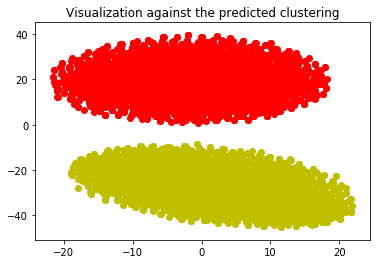

In [0]:
time_start = time.time()
tsne_model = TSNE(random_state = 42)
print(f'TSNE started. Time collapsed = {(time.time()-time_start):.2f}s')
tsne = tsne_model.fit_transform(X)
print(f'TSNE completed. Time collapsed = {(time.time()-time_start):.2f}s')
for i in range(len(tsne)):
  plt.scatter(tsne[i][0], tsne[i][1], c=colors[y_pred_train[i]])
print(f'done. Time collapsed ={time.time()-time_start}')
plt.title('Visualization against the predicted clustering')
plt.show()

.................................................................................................................................................................................................................................................................................................................................................................................................................

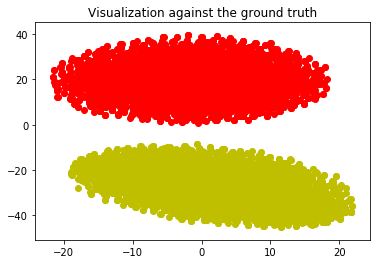

In [0]:
for i in range(len(tsne)):
  plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(labels[i][0].item())])
  if(i%25==0):
    print('.', end = '')  
plt.title('Visualization against the ground truth')
plt.show()

In [0]:
y_pred_train = torch.from_numpy(y_pred_train).type(torch.ByteTensor)#.cuda()
# labels = labels.cuda()
a = y_pred_train.type(torch.ByteTensor)
a = 1 - a 
accuracy = torch.mean((a == labels).type(torch.FloatTensor))
accuracy = accuracy.cpu()
print(f'Gaussian Mixture Model Accuracy = {(accuracy)*100:.2f}%')

Gaussian Mixture Model Accuracy = 50.00%


In [0]:
uni = sparse()
(uni[90:96])

torch.Size([39, 1])


tensor([[-1.4063e-01, -2.8145e-01,  4.4411e-01,  5.8321e-02, -2.1524e-01,
          8.6211e-02, -1.0329e-01,  1.2181e-01,  7.2102e-01, -2.8954e-01,
          1.5922e-02,  1.0000e+00,  2.3463e-02, -4.5925e-02, -5.2821e-02,
          3.5522e-01, -1.6904e-04, -4.1855e-01,  1.2959e-01,  3.0241e-01,
         -1.7134e-01, -2.2824e-01, -2.7596e-01, -1.2453e-01, -9.1200e-02,
          1.3983e-01, -2.4867e-01,  4.8624e-02, -1.4572e-01, -9.8532e-02,
          4.0182e-01,  1.1139e-01, -7.1844e-02, -2.2730e-01, -9.3280e-02,
         -6.3991e-01, -9.7520e-02, -3.8303e-01,  4.2248e-01],
        [-6.9391e-01,  3.8642e-01, -3.8027e-01, -4.3062e-01,  3.5098e-01,
         -5.5339e-01,  3.5102e-01, -2.6369e-01, -8.6607e-02, -1.0981e-01,
          2.5792e-01,  1.0000e+00, -1.0263e-01, -1.6609e-01,  2.7656e-01,
          1.4986e-01, -4.4353e-01, -2.9889e-01,  2.4021e-02, -6.1056e-01,
          5.3332e-03,  2.5645e-01,  2.4435e-01, -5.7948e-03, -5.7108e-01,
         -2.6533e-01,  2.5154e-01,  3.0417e-03, -1

In [0]:
a = nn.Softmax(dim = 0)(uni[90])

In [0]:
torch.sum(a)

tensor(1.0000)

In [0]:
torch.max(a)

tensor(0.0642)

In [0]:
a = y_pred_train.type(torch.ByteTensor)
1 - a 

tensor([1, 1, 0,  ..., 0, 1, 0], dtype=torch.uint8)

In [0]:
a

tensor([0, 0, 1,  ..., 1, 0, 1], dtype=torch.uint8)

## KMeans

In [0]:
kmodel = KMeans(n_clusters = 2, random_state = 42)
y_pred_train = None
time_means_start = time.time()
kmeans = kmodel.fit(X)
print(f'KMeans completed. Time elapsed = {time.time()-time_means_start:.2f}s')
y_pred_train = kmeans.labels_
train_accuracy = torch.mean((torch.from_numpy(kmeans.labels_) == labels).type(torch.FloatTensor))
print(train_accuracy)
print(f'Done time elapsed = {time.time()-time_means_start:.2f}s')

KMeans completed. Time elapsed = 0.14s
tensor(0.5000)
Done time elapsed = 0.35s


.....................................................................................................

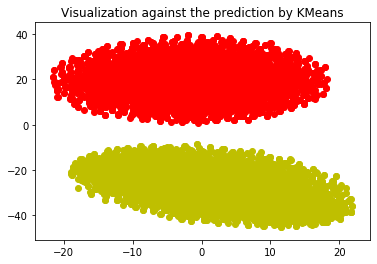

In [0]:
for i in range(len(tsne)):
  plt.scatter(tsne[i][0], tsne[i][1], c=colors[kmeans.labels_[i]])
  if(i%100==0):
    print('.', end = '')  
plt.title('Visualization against the prediction by KMeans')
plt.show()

## Autoencoder

In [0]:
class encoder(nn.Module):
  def __init__(self):
    super(encoder).__init__()
    self.fc1 = nn.Sequential(nn.Linear(39, 2), 
                             nn.LogSoftmax(dim = 1))
  def forward(self, X):
    X = self.fc1(X)
    return X

In [0]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc2 = nn.Sequential(nn.Linear(2,39),
                             nn.Softmax(dim = 1))
  def forward(self, X):
    X = self.fc2(X)
    return X

In [0]:
class Autoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
  def forward(self, X):
    X = self.enc(X)
    X = self.dec(X)
    return X

In [0]:
enc = encoder()
dec = decoder()
autoencoder = Autoencoder(enc, dec)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

Autoencoder(
  (enc): encoder(
    (fc1): Sequential(
      (0): Linear(in_features=39, out_features=2, bias=True)
      (1): LogSoftmax()
    )
  )
  (dec): decoder(
    (fc2): Sequential(
      (0): Linear(in_features=2, out_features=39, bias=True)
      (1): Softmax(dim=1)
    )
  )
)

In [0]:
epochs = 10
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [0]:
X = X.to(device)

In [0]:
def train():
  
  autoencoder.train()
  train_loss = 0
  
  

  optimizer.zero_grad()

  X_p = autoencoder(X)

  loss = criterion(X_p, X)
  
  loss.backward()
  train_loss += loss.item()
  
  optimizer.step()
  return train_loss

In [0]:
def test():
  autoencoder.eval()
  test_loss = 0

  with torch.no_grad():

    X_p = autoencoder(X)

    loss = criterion(X_p, X)

    test_loss += loss.item()
  return test_loss

In [0]:
train_loss_list = []
# test_loss_list = []
time_start = time.time()
for e in range(epochs):
  print(f'{e+1}th epoch...')
  print(f'Training...')
  train_loss = train()
  train_loss /= len(X)
  print(f'Training done. Time Collapsed = {time.time() - time_start: .2f}s')
  # print(f'Testing..')
  # test_loss = test()
  # test_loss /= len(val_data)
  # print(f'Testing done. Time Collapsed = {time.time() - time_start: .2f}s')
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)

1th epoch...
Training...
Training done. Time Collapsed =  0.02s
2th epoch...
Training...
Training done. Time Collapsed =  0.04s
3th epoch...
Training...
Training done. Time Collapsed =  0.05s
4th epoch...
Training...
Training done. Time Collapsed =  0.07s
5th epoch...
Training...
Training done. Time Collapsed =  0.08s
6th epoch...
Training...
Training done. Time Collapsed =  0.10s
7th epoch...
Training...
Training done. Time Collapsed =  0.11s
8th epoch...
Training...
Training done. Time Collapsed =  0.13s
9th epoch...
Training...
Training done. Time Collapsed =  0.14s
10th epoch...
Training...
Training done. Time Collapsed =  0.16s


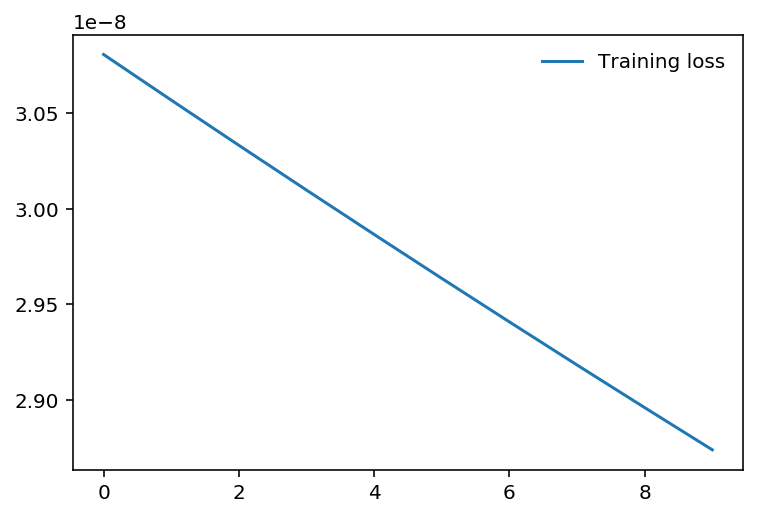

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
# plt.plot(test_loss_list, label='Validation loss')
plt.legend(frameon=False)

done time elapsed = 110.50s


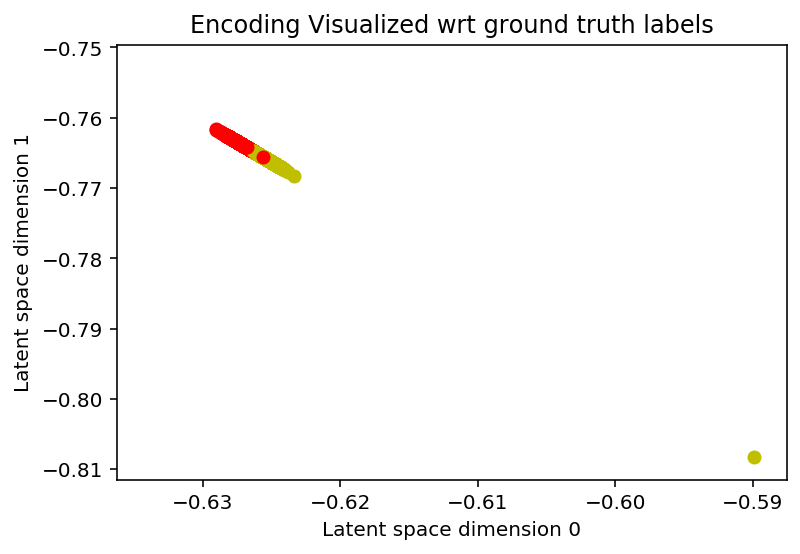

In [0]:
with torch.no_grad():
  enc.eval()
  enc.to(device)
  time_embedding = time.time()

  z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(labels[i][0].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt ground truth labels')
  plt.show()

In [0]:
y_pred = torch.argmax(z.type(torch.LongTensor), dim = 1)
accuracy = torch.mean((y_pred==labels).type(torch.FloatTensor))
print(f'accuracy = {(accuracy/len(X)*100):.3f}%')

accuracy = 0.005%


In [0]:
y_pred[1].item()

1

done time elapsed = 637.63s


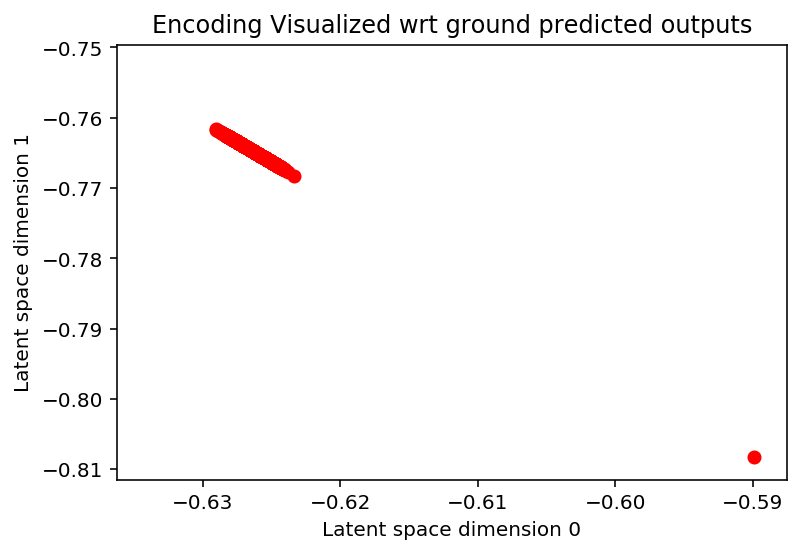

In [0]:
with torch.no_grad():
  # enc.eval()
  # enc.to(device)
  # time_embedding = time.time()

  # z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(y_pred[i].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt ground predicted outputs')
  plt.show()